# Traget:
Build a inverse kinematics model by using Backpropagation neural network (BPNN) to solve θ1, θ2, θ3 if X, Y, Z are given. The program of the model needs to be written in Python language and use the Pytorch package. You can refer to the attached python program but use the Tensorflow package
#### input: X, Y, Z
#### output: θ1, θ2, θ3

## connect the drive

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
!ls -l

total 1504
drwx------ 5 root root    4096 Apr 19 13:02 drive
drwxr-xr-x 1 root root    4096 Apr 14 13:35 sample_data
-rw-r--r-- 1 root root  152584 Apr 19 13:01 test.csv
-rw-r--r-- 1 root root 1067767 Apr 19 13:01 train.csv
-rw-r--r-- 1 root root  305082 Apr 19 13:01 valid.csv


## BPNN

## import package

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

## Check GPU info.
ref: https://towardsdatascience.com/installing-pytorch-on-apple-m1-chip-with-gpu-acceleration-3351dc44d67c

In [35]:
# this ensures that the current MacOS version is at least 12.3+
print(torch.cuda.is_available())

True


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(device)

cuda


## datasets
generate datasets from file: Hw04_1_generate_data.ipynb.

In [37]:
# path
train_path = "/content/train.csv"
valid_path = "/content/valid.csv"
test_path = "/content/test.csv"
#  讀取數據
train_data = pd.read_csv(train_path, header=None).values
valid_data = pd.read_csv(valid_path, header=None).values
test_data = pd.read_csv(test_path, header=None).values

# 將數據轉換成 PyTorch 張量
train_inputs = torch.from_numpy(train_data[:, :3]).float().to(device=device)
train_outputs = torch.from_numpy(train_data[:, 3:]).float().to(device=device)
valid_inputs = torch.from_numpy(valid_data[:, :3]).float().to(device=device)
valid_outputs = torch.from_numpy(valid_data[:, 3:]).float().to(device=device)
test_inputs = torch.from_numpy(test_data[:, :3]).float().to(device=device)
test_outputs = torch.from_numpy(test_data[:, 3:]).float().to(device=device)

print("train data shape:", train_data.shape)
print("valid data shape:", valid_data.shape)
print("test data shape:", test_data.shape)

train data shape: (7000, 6)
valid data shape: (2000, 6)
test data shape: (1000, 6)


## model
ref: https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity

In [38]:
class BPNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BPNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU6(),
            nn.Tanh(),
            nn.Dropout(p=0.6),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU6(),
            nn.Tanh(),
            nn.Dropout(p=0.2),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self, x):
        x = self.layers(x)
        return x


## parameter

In [39]:
# 設定模型參數
input_size = 3
hidden_size = 64
output_size = 3
learning_rate = 0.1
num_epochs = 100
batch = 64

In [40]:
# 使用TensorDataset和DataLoader進行批次讀取
train_dataset = TensorDataset(train_inputs, train_outputs)
train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
valid_dataset = TensorDataset(valid_inputs, valid_outputs)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch, shuffle=True)

## loss and optimizer

In [41]:
# 建立 BPNN 模型
model = BPNN(input_size, hidden_size, output_size).to(device=device)

# 定義損失函數和優化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999)) ## momentum
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)


## train

In [42]:
# 創建進度條
pbar = tqdm(total=num_epochs)

train_loss, valid_loss = [], [] # 紀錄loss
for epoch in range(num_epochs):
    for (x, target) in train_dataloader:
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    # validation
    model.eval()

    for (x, target) in valid_dataloader:
        output = model(x)
        loss = criterion(output, target)
        valid_loss.append(loss.item())

    # 更新進度條的顯示信息
    pbar.set_postfix({'Train Loss': np.mean(train_loss), 'Valid Loss': np.mean(valid_loss)})
    pbar.update()

    # 更新學習率
    scheduler.step()

# 關閉進度條
pbar.close()

100%|██████████| 100/100 [00:23<00:00,  4.19it/s, Train Loss=0.328, Valid Loss=0.327]


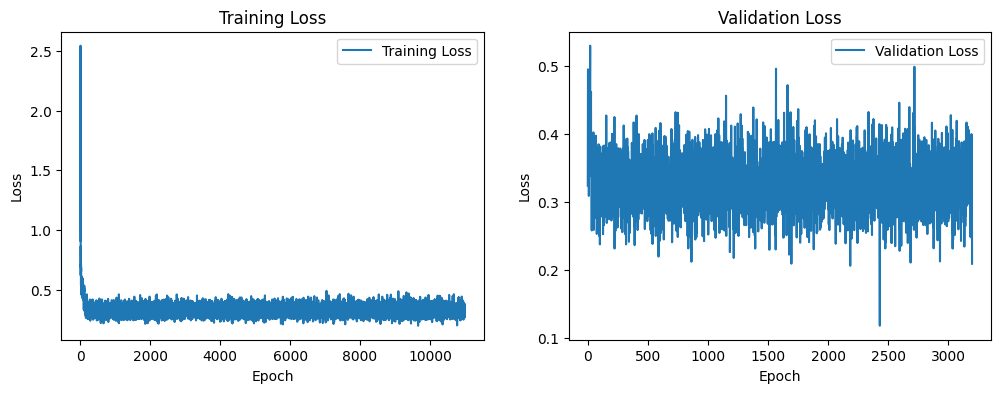

In [43]:
import matplotlib.pyplot as plt

# 繪製訓練集和驗證集的損失曲線
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(train_loss, label='Training Loss')
axs[0].set_title('Training Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(valid_loss, label='Validation Loss')
axs[1].set_title('Validation Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.show()


## test

In [44]:
from tabulate import tabulate

# 在測試集上評估模型
with torch.no_grad():
    test_outputs_pred = model(test_inputs)
    test_loss = criterion(test_outputs_pred, test_outputs)
    print(f'Test Loss: {test_loss.item():.4f}')

    # 整理數據
    data = []
    for i in range(len(test_inputs[:9])):
        x1, x2, x3, yd, yp = test_inputs[i][0], test_inputs[i][1], test_inputs[i][2], test_outputs[i], test_outputs_pred[i]
        loss = yd - yp
        row = [x1.item(), x2.item(), x3.item(), yd[0].item(), yd[1].item(), yd[2].item(), yp[0].item(), yp[1].item(), yp[2].item(), loss[0].item(), loss[1].item(), loss[2].item()]
        data.append(row)

    # 輸出表格
    headers = ["x1", "x2", "x3", "yd1", "yd2", "yd3", "yp1", "yp2", "yp3", "L1", "L2", "L3"]
    print(tabulate(data, headers=headers, floatfmt=".4f"))


Test Loss: 0.3421
      x1         x2         x3      yd1      yd2      yd3      yp1      yp2      yp3       L1       L2       L3
--------  ---------  ---------  -------  -------  -------  -------  -------  -------  -------  -------  -------
100.4518   233.3061  -145.0876   1.1642   1.2137  -1.0868   1.3141   0.5613   0.1628  -0.1499   0.6524  -1.2496
 33.8210   304.0570   -63.7883   1.4600   0.7328  -0.9142   1.3029   0.5396   0.1471   0.1571   0.1932  -1.0613
 29.5888  -294.9337    51.9071  -1.4708   0.3549  -1.0922  -1.1879  -0.4575  -0.1003  -0.2829   0.8124  -0.9919
-36.9933   -46.7328   162.4600   0.9012  -1.3965  -1.5430  -0.2217  -1.2698  -0.8422   1.1229  -0.1268  -0.7008
 38.2820    92.8940  -272.5775   1.1799   1.2010   0.4333   0.7458   0.9955   0.5345   0.4341   0.2055  -0.1013
 76.5481  -308.3983   116.6177  -1.3275  -0.4239  -0.0047  -1.1879  -0.4575  -0.1003  -0.1396   0.0336   0.0956
 10.8779    11.3436  -271.2765   0.8064   1.5035   0.4460   0.2388   1.2394   0.7662  